# Выбираем авто выгодно

## План решения:

1. Анализ тестового набора для определения параметров выборки с сайита auto.ru
2. По полученным критериям получить список линков на объявления о продаже авто
3. По списку, используя wget, скачать страницы на локальный диск
4. Парсинг страниц - получение тренировочного датасета
5. EDA
6. Подготовка данных к работе (очистка, кодирование, масштабирование)
7. Построение наивной модели
8. Получение первых результатов и метрики локально и на kaggle
9-N Feature engeneering и model selection

In [394]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import json
from sklearn.model_selection import train_test_split
import os
#from lazypredict.Supervised import LazyRegressor


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
#from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [199]:
RANDOM_SEED = 42

In [200]:
DIR_TRAIN  = './' # подключил к ноутбуку внешний датасет
DIR_TEST   = './'
VAL_SIZE   = 0.25   # 25%
SUBMIT_MODE = False

In [201]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [202]:
test = pd.read_csv(DIR_TEST + 'test.csv')
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [203]:
# чтобы профайлер не запускался каждый раз
if not SUBMIT_MODE and not os.path.exists("test_profile.html"):
    profile = ProfileReport(test, title="Pandas Profiling Report")
    profile.to_file("test_profile.html")
    profile.to_notebook_iframe()

In [204]:
test = pd.read_csv(DIR_TEST + 'test.csv')
# Определимся с признаками, которые стоит парсить с сайта
# remove constant features
test = test.drop(['priceCurrency', 'Состояние', 'Таможня'], axis=1)
# remove mach missing features
test = test.drop(['complectation_dict', 'Владение'], axis=1)
# remove high correlated features
test = test.drop(['vendor'], axis=1) # Марка модели однозначно определяет вендора
# remove unique features
test = test.drop(['parsing_unixtime', 'image'], axis=1)

In [205]:
# Body type from vehicleConfiguration
test['body_type'] = test['vehicleConfiguration'].apply(lambda x: x.split(' ')[0])
test = test.drop('bodyType', axis=1)
test = test.drop('vehicleConfiguration', axis=1)

In [206]:
# Технические хаарактеристики из super_gen
test['tech_param'] = test['super_gen'].apply(lambda x: json.loads(x))
test = test.drop('super_gen', axis=1)
test['displacement'] = test['tech_param'].apply(lambda x: x["displacement"])
test['engine_type'] = test['tech_param'].apply(lambda x: x["engine_type"])
test['gear_type'] = test['tech_param'].apply(lambda x: x["gear_type"])
test['transmission'] = test['tech_param'].apply(lambda x: x["transmission"])
test['power'] = test['tech_param'].apply(lambda x: x["power"])
test['acceleration'] = test['tech_param'].apply(lambda x: x.get("acceleration", np.nan))
test['clearance_min'] = test['tech_param'].apply(lambda x: x.get("clearance_min", np.nan))
test['fuel_rate'] = test['tech_param'].apply(lambda x: x.get("fuel_rate", np.nan))
test = test.drop(['fuelType', 'engineDisplacement', 'enginePower', 'vehicleTransmission', 'Привод'], axis=1)

In [207]:
# Название модели из model_info
test['model_info'] = test['model_info'].apply(lambda x: json.loads(x))
test['model_name'] = test['model_info'].apply(lambda x: x["code"])
test = test.drop(['model_info', 'name'], axis=1)

In [208]:
test.columns

Index(['brand', 'car_url', 'color', 'description', 'equipment_dict', 'mileage',
       'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'Владельцы', 'ПТС', 'Руль', 'body_type', 'tech_param', 'displacement',
       'engine_type', 'gear_type', 'transmission', 'power', 'acceleration',
       'clearance_min', 'fuel_rate'],
      dtype='object')

### Итак вытаскиваем только эти признаки
Парсер лежит в файле grabber.ipynb

In [209]:
train = pd.read_json(DIR_TRAIN + 'train.json', lines=True)
train.head(2)

,car_url,brand,color,steering_wheel,body_type,description,equipment_dict,mileage,modelDate,model_info,numberOfDoors,productionDate,owners,pts_original,tech_param,price_info
0,https://auto.ru/cars/used/sale/audi/a6/1104922...,AUDI,серый,LEFT,SEDAN,Отличное внешнее и техническое состояние. \nПо...,"{'cruise-control': True, 'asr': True, 'tinted-...",219000,2004,"{'code': 'A6', 'name': 'A6', 'ru_name': 'А6', ...",4,2004,2,1.0,"{'id': '6297726', 'displacement': 2976, 'engin...","{'price': 575000, 'currency': 'RUR', 'EUR': 66..."
1,https://auto.ru/cars/used/sale/audi/rs4/110272...,AUDI,серый,LEFT,WAGON_5_DOORS,Цена 5600 пока есть в продаже интересующий мен...,"{'cruise-control': True, 'asr': True, 'tinted-...",50500,2017,"{'code': 'RS4', 'name': 'RS 4', 'ru_name': 'РС...",5,2017,2,1.0,"{'id': '21093313', 'displacement': 2894, 'engi...","{'price': 5600000, 'currency': 'RUR', 'EUR': 6..."


In [210]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28857 entries, 0 to 28856
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   car_url         28857 non-null  object 
 1   brand           28857 non-null  object 
 2   color           28857 non-null  object 
 3   steering_wheel  28857 non-null  object 
 4   body_type       28857 non-null  object 
 5   description     27987 non-null  object 
 6   equipment_dict  28857 non-null  object 
 7   mileage         28857 non-null  int64  
 8   modelDate       28857 non-null  int64  
 9   model_info      28857 non-null  object 
 10  numberOfDoors   28857 non-null  int64  
 11  productionDate  28857 non-null  int64  
 12  owners          28857 non-null  int64  
 13  pts_original    24684 non-null  float64
 14  tech_param      28857 non-null  object 
 15  price_info      28857 non-null  object 
dtypes: float64(1), int64(5), object(10)
memory usage: 3.5+ MB


In [211]:
# чтобы профайлер не запускался каждый раз
if not SUBMIT_MODE and not os.path.exists("train_profile.html"):
    profile_train = ProfileReport(train, title="Pandas Profiling Report")
    profile_train.to_file("train_profile.html")
    profile_train.to_notebook_iframe()

In [212]:
# Технические хаарактеристики из super_gen
train['displacement'] = train['tech_param'].apply(lambda x: x["displacement"])
train['engine_type'] = train['tech_param'].apply(lambda x: x["engine_type"])
train['gear_type'] = train['tech_param'].apply(lambda x: x["gear_type"])
train['transmission'] = train['tech_param'].apply(lambda x: x["transmission"])
train['power'] = train['tech_param'].apply(lambda x: x["power"])
train['acceleration'] = train['tech_param'].apply(lambda x: x.get("acceleration", np.nan))
train['clearance_min'] = train['tech_param'].apply(lambda x: x.get("clearance_min", np.nan))
train['fuel_rate'] = train['tech_param'].apply(lambda x: x.get("fuel_rate", np.nan))
train['model_name'] = train['model_info'].apply(lambda x: x['code'])
train['price'] = train['price_info'].apply(lambda x: x.get('price', np.nan))
# На трейне sell_id нас не интересует, но для сохранения структуры пусть будет 0 
train['sell_id'] = 0

In [213]:
# Некоторые цены пустые - удаляем
train = train[train['price'].notna()]
train['price'].isna().sum()

0

### Очистка данных и приведение теста и трейна к одному виду

In [214]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           34686 non-null  object 
 1   car_url         34686 non-null  object 
 2   color           34686 non-null  object 
 3   description     34686 non-null  object 
 4   equipment_dict  24690 non-null  object 
 5   mileage         34686 non-null  int64  
 6   modelDate       34686 non-null  int64  
 7   model_name      34686 non-null  object 
 8   numberOfDoors   34686 non-null  int64  
 9   productionDate  34686 non-null  int64  
 10  sell_id         34686 non-null  int64  
 11  Владельцы       34686 non-null  object 
 12  ПТС             34685 non-null  object 
 13  Руль            34686 non-null  object 
 14  body_type       34686 non-null  object 
 15  tech_param      34686 non-null  object 
 16  displacement    34686 non-null  int64  
 17  engine_type     34686 non-null 

In [215]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28754 entries, 0 to 28856
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   car_url         28754 non-null  object 
 1   brand           28754 non-null  object 
 2   color           28754 non-null  object 
 3   steering_wheel  28754 non-null  object 
 4   body_type       28754 non-null  object 
 5   description     27885 non-null  object 
 6   equipment_dict  28754 non-null  object 
 7   mileage         28754 non-null  int64  
 8   modelDate       28754 non-null  int64  
 9   model_info      28754 non-null  object 
 10  numberOfDoors   28754 non-null  int64  
 11  productionDate  28754 non-null  int64  
 12  owners          28754 non-null  int64  
 13  pts_original    24599 non-null  float64
 14  tech_param      28754 non-null  object 
 15  price_info      28754 non-null  object 
 16  displacement    28754 non-null  int64  
 17  engine_type     28754 non-null 

In [216]:
# Приводим к однотипности train и test 
test_df = test[['brand', 'color', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate',
                'Владельцы', 'ПТС', 'Руль', 'body_type', 'displacement', 'engine_type', 'gear_type', 
                'transmission', 'power', 'acceleration', 'clearance_min', 'fuel_rate',
                'description', 'equipment_dict', 'sell_id']].copy()
# Сразу добавим price = 0 для последующего объединения наборов (чтобы закодировать категориальные признаки)
test_df['price'] = 0
test_df.head(2)

,brand,color,mileage,modelDate,model_name,numberOfDoors,productionDate,Владельцы,ПТС,Руль,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
0,SKODA,синий,74000,2013,OCTAVIA,5,2014,3 или более,Оригинал,Левый,...,FORWARD_CONTROL,ROBOT,105,10.5,155.0,5.0,"Все автомобили, представленные в продаже, прох...","{""engine-proof"":true,""tinted-glass"":true,""airb...",1100575026,0
1,SKODA,чёрный,60563,2017,OCTAVIA,5,2017,1 владелец,Оригинал,Левый,...,FORWARD_CONTROL,MECHANICAL,110,10.8,156.0,6.4,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",1100549428,0


In [217]:
train_df = train[['brand', 'color', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate',
                  'owners', 'pts_original', 'steering_wheel', 'body_type', 'displacement', 'engine_type', 
                  'gear_type', 'transmission', 'power', 'acceleration', 'clearance_min', 'fuel_rate',
                  'description', 'equipment_dict', 'sell_id', 'price']].copy()
train_df.head(2)

,brand,color,mileage,modelDate,model_name,numberOfDoors,productionDate,owners,pts_original,steering_wheel,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
0,AUDI,серый,219000,2004,A6,4,2004,2,1.0,LEFT,...,ALL_WHEEL_DRIVE,AUTOMATIC,218,8.1,168.0,11.3,Отличное внешнее и техническое состояние. \nПо...,"{'cruise-control': True, 'asr': True, 'tinted-...",0,575000.0
1,AUDI,серый,50500,2017,RS4,5,2017,2,1.0,LEFT,...,ALL_WHEEL_DRIVE,AUTOMATIC,450,4.1,120.0,8.8,Цена 5600 пока есть в продаже интересующий мен...,"{'cruise-control': True, 'asr': True, 'tinted-...",0,5600000.0


In [218]:
columns = ['brand', 'color', 'mileage', 'model_date', 'model_name', 'number_of_doors', 'production_date',
           'owners', 'pts_original', 'steering_wheel', 'body_type', 'displacement', 'engine_type', 
           'gear_type', 'transmission', 'power', 'acceleration', 'clearance_min', 'fuel_rate',
           'description', 'equipment_dict', 'sell_id', 'price']
test_df.columns = columns
train_df.columns = columns

In [219]:
test_df['owners'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [220]:
test_df['owners'] = test_df['owners'].map({'3 или более': 3, '1\xa0владелец': 1, '2\xa0владельца': 2})
test_df['owners'].unique()

array([3, 1, 2])

In [221]:
train_df['owners'].unique()

array([2, 4, 1, 3])

In [222]:
train_df['owners'] = train_df['owners'].map({1: 1, 2: 2, 3: 3, 4: 3})
train_df['owners'].unique()

array([2, 3, 1])

In [223]:
test_df['pts_original'].unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

In [224]:
test_df['pts_original'] = test_df['pts_original'].map({'Оригинал': 1, 'Дубликат': 0}).fillna(0).astype(int)
test_df['pts_original'].unique()

array([1, 0])

In [225]:
train_df['pts_original'].unique()

array([ 1., nan])

In [226]:
train_df['pts_original'] = train_df['pts_original'].fillna(0).astype(int)
train_df['pts_original'].unique()

array([1, 0])

In [227]:
test_df['steering_wheel'].unique()

array(['Левый', 'Правый'], dtype=object)

In [228]:
test_df['steering_wheel'] = test_df['steering_wheel'].map({'Левый': 1, 'Правый': 0}).astype(int)
test_df['steering_wheel'].unique()

array([1, 0])

In [229]:
train_df['steering_wheel'].unique()

array(['LEFT', 'RIGHT'], dtype=object)

In [230]:
train_df['steering_wheel'] = train_df['steering_wheel'].map({'LEFT': 1, 'RIGHT': 0}).astype(int)
train_df['steering_wheel'].unique()

array([1, 0])

In [231]:
test_df.iloc[0, :]

brand                                                          SKODA
color                                                          синий
mileage                                                        74000
model_date                                                      2013
model_name                                                   OCTAVIA
number_of_doors                                                    5
production_date                                                 2014
owners                                                             3
pts_original                                                       1
steering_wheel                                                     1
body_type                                                   LIFTBACK
displacement                                                    1197
engine_type                                                 GASOLINE
gear_type                                            FORWARD_CONTROL
transmission                      

In [232]:
train_df.iloc[0, :]

brand                                                           AUDI
color                                                          серый
mileage                                                       219000
model_date                                                      2004
model_name                                                        A6
number_of_doors                                                    4
production_date                                                 2004
owners                                                             2
pts_original                                                       1
steering_wheel                                                     1
body_type                                                      SEDAN
displacement                                                    2976
engine_type                                                 GASOLINE
gear_type                                            ALL_WHEEL_DRIVE
transmission                      

In [233]:
# Посмотрим на различия в категориальных переменных
cat_features = ['brand', 'color', 'model_name', 'body_type', 'engine_type', 'gear_type', 'transmission']
for column in cat_features:
    print(column, '=>', set(test_df[column].unique()).symmetric_difference(set(train_df[column].unique())))

brand => set()
color => set()
model_name => {'CLIPPER_RIO', 'RUSH', 'PASSAT_NA', 'JADE', 'TITAN', 'BLIZZARD', 'EK_CUSTOM', 'BEAT', 'DELICA_D2', 'SANTANA', 'DELICA_D3', 'ALLEX', '300_SERIES', 'CROSSROAD', 'CLK_KLASSE_AMG', 'X3_M', 'VAMOS', '280ZX', 'CROWN_MAJESTA', 'TACOMA', 'CABRIOLET', 'YARIS_VERSO', 'CALIFORNIA', '100NX', 'POPULAR', '200SX', 'Q3_SPORTBACK', 'CARAVAN_COACH', 'Z', 'METRIS', '760', 'TARO', 'SERA', 'PRIUSPLUS', '02', 'M1', 'RACTIS', 'CIVIC_FERIO', 'HS', 'MODEL_F', 'ELYSION', 'E3', 'GTO', 'CELSIOR', 'SPARKY', 'GOLF_COUNTRY', 'TANK', 'BLADE', 'TOPPO', 'ATLAS', 'ENDEAVOR', 'PIXIS_VAN', 'ALLION', 'RAFAGA', 'TYPE_2', 'EQC', 'CRESSIDA', 'SLC_KLASSE_AMG', 'CAVALIER', 'EK_ACTIVE', 'CAPA', '180SX', 'M8', '502', 'ASPIRE', 'ROGUE', 'CR_X', 'NV350_CARAVAN', 'E_TRON_SPORTBACK', 'GRACE', 'IS_F', '100_SERIES', '600', 'CIMA', 'PASSPORT', 'PROACE', 'E_TRON_S', 'ORIGIN', '2000_C_CS', 'SLK_KLASSE_AMG', 'GRANVIA', 'XTERRA', '326', 'W189', 'MARK_X_ZIO', 'KIX', '3000_GT', 'SIMPLEX', 'CHALLENG

In [234]:
# Посмотрим сколько строк с категориальными переменными есть в тесте и нет в трейне
body_type_diff = set(test_df['body_type'].unique()).symmetric_difference(set(train_df['body_type'].unique()))
test_df[(test_df['body_type'].isin(body_type_diff))]

,brand,color,mileage,model_date,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
11764,NISSAN,серебристый,2000,1978,280ZX,3,1980,2,0,0,...,REAR_DRIVE,MECHANICAL,145,NaN,135.0,NaN,"Легендарное спорт купе Ниссан 280zx, выпущен в...",NaN,1099081002,0


In [235]:
model_name_diff = set(test_df['model_name'].unique()).symmetric_difference(set(train_df['model_name'].unique()))
test_df[(test_df['model_name'].isin(model_name_diff))]

,brand,color,mileage,model_date,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
771,SKODA,белый,74969,1969,100_SERIES,4,1976,1,1,1,...,REAR_DRIVE,MECHANICAL,42,NaN,178.0,NaN,Цена без документов 76000р.\n\nНа автомобиль п...,NaN,1096411742,0
1777,SKODA,чёрный,14000,1934,POPULAR,3,1939,3,1,1,...,REAR_DRIVE,MECHANICAL,30,NaN,NaN,NaN,"Авто после длительного простоя, под восстановл...",NaN,1097046168,0
5269,HONDA,чёрный,249000,2006,ELYSION,5,2010,2,1,0,...,ALL_WHEEL_DRIVE,AUTOMATIC,160,13.5,165.0,10.0,Продаю самый комфортный семейный минивэн. РЕГ...,"{""alloy-wheel-disks"":true,""16-inch-wheels"":tru...",1100443422,0
5361,HONDA,зелёный,132000,1998,Z,3,2000,2,1,0,...,ALL_WHEEL_DRIVE,AUTOMATIC,64,NaN,195.0,6.4,"В машину сел и поехал,никаких вложений не треб...",NaN,1101306217,0
5362,HONDA,белый,320000,2000,CIVIC_FERIO,4,2003,3,1,0,...,FORWARD_CONTROL,AUTOMATIC,105,NaN,155.0,NaN,"Авто технически в хорошем состоянии, есть деф...","{""lock"":true}",1101221208,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30463,VOLKSWAGEN,белый,10899,2017,ATLAS,5,2018,1,1,1,...,FORWARD_CONTROL,AUTOMATIC,238,NaN,203.0,NaN,Комфорт: 7. Безопасность: 5. Мультимедиа: 4. З...,"{""electro-window-back"":true,""airbag-driver"":tr...",1101325868,0
31443,VOLVO,красный,250000,1982,760,4,1985,3,0,1,...,REAR_DRIVE,MECHANICAL,156,10.0,105.0,11.3,На ходу. Документы есть (с документами все в п...,NaN,1101339198,0
32071,HONDA,синий,150000,1995,CIVIC_FERIO,4,1998,3,1,0,...,FORWARD_CONTROL,AUTOMATIC,105,NaN,150.0,NaN,"Новые пороги и арки, по дну живая. двигатель, ...",NaN,1101361090,0
33369,TOYOTA,белый,133000,2011,PRIUSPLUS,5,2012,1,1,1,...,FORWARD_CONTROL,AUTOMATIC,99,11.3,145.0,4.1,"Максимальная комплектация(7 мест,панорама,адап...","{""engine-proof"":true,""tinted-glass"":true,""esp""...",1084108403,0


In [268]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28754 entries, 0 to 28856
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            28754 non-null  object 
 1   color            28754 non-null  object 
 2   mileage          28754 non-null  int64  
 3   model_date       28754 non-null  int64  
 4   model_name       28754 non-null  object 
 5   number_of_doors  28754 non-null  int64  
 6   production_date  28754 non-null  int64  
 7   owners           28754 non-null  int64  
 8   pts_original     28754 non-null  int64  
 9   steering_wheel   28754 non-null  int64  
 10  body_type        28754 non-null  object 
 11  displacement     28754 non-null  int64  
 12  engine_type      28754 non-null  object 
 13  gear_type        28754 non-null  object 
 14  transmission     28754 non-null  object 
 15  power            28754 non-null  int64  
 16  acceleration     28251 non-null  float64
 17  clearance_mi

In [397]:
# При кодировании этих признаков нужно объединить два набора
sum_df = pd.concat([test_df, train_df])
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28517 entries, 12795 to 23915
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            28517 non-null  object 
 1   color            28517 non-null  object 
 2   mileage          28517 non-null  int64  
 3   model_name       28517 non-null  object 
 4   number_of_doors  28517 non-null  int64  
 5   production_date  28517 non-null  int64  
 6   owners           28517 non-null  int64  
 7   pts_original     28517 non-null  int64  
 8   steering_wheel   28517 non-null  int64  
 9   body_type        28517 non-null  object 
 10  displacement     28517 non-null  int64  
 11  engine_type      28517 non-null  object 
 12  gear_type        28517 non-null  object 
 13  transmission     28517 non-null  object 
 14  power            28517 non-null  int64  
 15  acceleration     28517 non-null  float64
 16  clearance_min    28517 non-null  float64
 17  fuel_rat

In [398]:
sum_df.sample(2)

,brand,color,mileage,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,body_type,displacement,engine_type,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,sell_id,price
28357,VOLVO,чёрный,456413,940,4,1995,2,0,1,SEDAN,2316,GASOLINE,REAR_DRIVE,MECHANICAL,165,9.1,105.0,9.9,0,75000.0
12238,MERCEDES,белый,125000,E_KLASSE,2,2011,3,1,1,COUPE_HARDTOP,1796,GASOLINE,REAR_DRIVE,AUTOMATIC,184,7.8,160.0,6.9,0,1350000.0


In [399]:
# Теперь в sum_df собраны вместе тест (price=0) и трейн (price!=0)

## EDA

In [400]:
# чтобы профайлер не запускался каждый раз
if not SUBMIT_MODE and not os.path.exists("sum_profile.html"):
    profile_train = ProfileReport(sum_df, title="Pandas Profiling Report")
    profile_train.to_file("sum_profile.html")
    profile_train.to_notebook_iframe()

In [401]:
# Сразу удалим признаки (description, equipment_dict) пока не будем их кодировать
sum_df.drop(['description', 'equipment_dict'], axis=1, inplace=True)

KeyError: "['description' 'equipment_dict'] not found in axis"

### Пропуски

In [402]:
# Пропуски заменим на средние по модели
sum_df.isna().sum()

brand              0
color              0
mileage            0
model_name         0
number_of_doors    0
production_date    0
owners             0
pts_original       0
steering_wheel     0
body_type          0
displacement       0
engine_type        0
gear_type          0
transmission       0
power              0
acceleration       0
clearance_min      0
fuel_rate          0
sell_id            0
price              0
dtype: int64

In [403]:
acceleration_dict = sum_df.groupby(['brand', 'model_name'])['acceleration'].mean().to_dict()
sum_df['acceleration'] = sum_df.apply(
    lambda row: row['acceleration'] if pd.notnull(row['acceleration']) else acceleration_dict[
        (row['brand'], row['model_name'])], 
    axis=1)

In [404]:
clearance_dict = sum_df.groupby(['brand', 'model_name'])['clearance_min'].mean().to_dict()
sum_df['clearance_min'] = sum_df.apply(
    lambda row: row['clearance_min'] if pd.notnull(row['clearance_min']) else clearance_dict[
        (row['brand'], row['model_name'])], 
    axis=1)

In [405]:
fuel_rate_dict = sum_df.groupby(['brand', 'model_name'])['fuel_rate'].mean().to_dict()
sum_df['fuel_rate'] = sum_df.apply(
    lambda row: row['fuel_rate'] if pd.notnull(row['fuel_rate']) else fuel_rate_dict[
        (row['brand'], row['model_name'])], 
    axis=1)

In [406]:
sum_df.isna().sum()

brand              0
color              0
mileage            0
model_name         0
number_of_doors    0
production_date    0
owners             0
pts_original       0
steering_wheel     0
body_type          0
displacement       0
engine_type        0
gear_type          0
transmission       0
power              0
acceleration       0
clearance_min      0
fuel_rate          0
sell_id            0
price              0
dtype: int64

In [407]:
# Оставшиеся пропуски заменим на типичные для машин с таким кузовом
_dict = sum_df.groupby(['body_type'])['acceleration'].mean().to_dict()
sum_df['acceleration'] = sum_df.apply(
    lambda row: row['acceleration'] if pd.notnull(row['acceleration']) else _dict[row['body_type']], 
    axis=1)
_dict = sum_df.groupby(['body_type'])['clearance_min'].mean().to_dict()
sum_df['clearance_min'] = sum_df.apply(
    lambda row: row['clearance_min'] if pd.notnull(row['clearance_min']) else _dict[row['body_type']], 
    axis=1)
_dict = sum_df.groupby(['body_type'])['fuel_rate'].mean().to_dict()
sum_df['fuel_rate'] = sum_df.apply(
    lambda row: row['fuel_rate'] if pd.notnull(row['fuel_rate']) else _dict[row['body_type']], 
    axis=1)

In [408]:
sum_df.isna().sum()

brand              0
color              0
mileage            0
model_name         0
number_of_doors    0
production_date    0
owners             0
pts_original       0
steering_wheel     0
body_type          0
displacement       0
engine_type        0
gear_type          0
transmission       0
power              0
acceleration       0
clearance_min      0
fuel_rate          0
sell_id            0
price              0
dtype: int64

In [409]:
# Оставшиеся пропуски заменим на типичные для машин с такой же мощностью
_dict = sum_df.groupby(['power'])['acceleration'].mean().to_dict()
sum_df['acceleration'] = sum_df.apply(
    lambda row: row['acceleration'] if pd.notnull(row['acceleration']) else _dict[row['power']], 
    axis=1)
_dict = sum_df.groupby(['power'])['fuel_rate'].mean().to_dict()
sum_df['fuel_rate'] = sum_df.apply(
    lambda row: row['fuel_rate'] if pd.notnull(row['fuel_rate']) else _dict[row['power']], 
    axis=1)

In [410]:
sum_df.isna().sum()

brand              0
color              0
mileage            0
model_name         0
number_of_doors    0
production_date    0
owners             0
pts_original       0
steering_wheel     0
body_type          0
displacement       0
engine_type        0
gear_type          0
transmission       0
power              0
acceleration       0
clearance_min      0
fuel_rate          0
sell_id            0
price              0
dtype: int64

### Выбросы

In [411]:
#!pip install -U seaborn

/Users/sand/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/sand/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



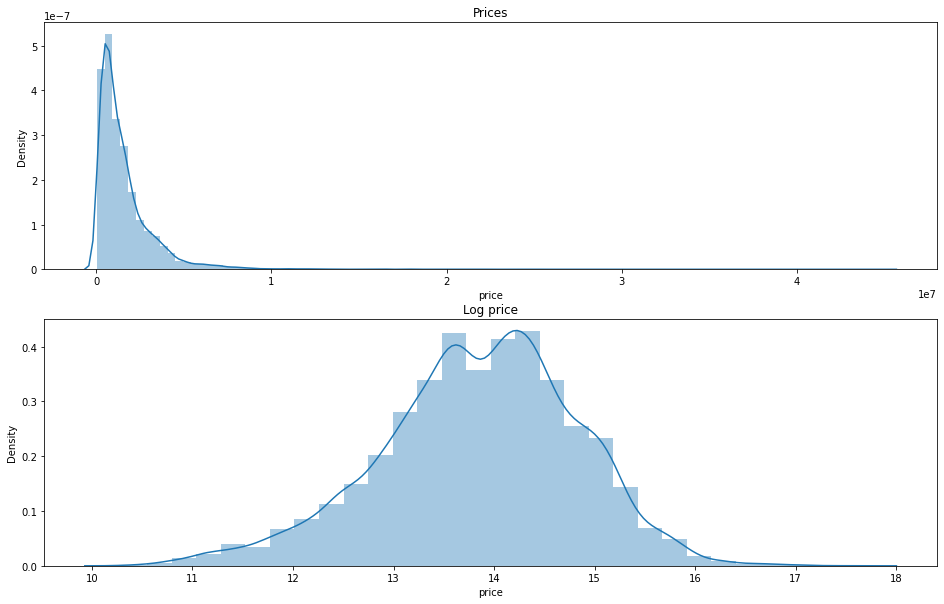

In [418]:
# Из всех признаков опасения вызывают экстремально высокие цены на авто
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 10)
indices = sum_df['price'] > 0
ax[0].set_title('Prices')
_ = sns.distplot(sum_df.loc[indices, 'price'], kde=True, bins=100, ax=ax[0])
ax[1].set_title('Log price')
_ = sns.distplot(np.log(sum_df.loc[indices, 'price']), kde=True, bins=30, ax=ax[1])
#     ax[1][0].set_title('Sqrt')
#     _ = sns.histplot(np.sqrt(no_zero_df), fill=True, kde=True, bins=30, ax=ax[1][0])
#     ax[1][1].set_title('BoxCox')
#     _ = sns.histplot(stats.boxcox(df.loc[indices, target])[0], fill=True, kde=True, bins=30, ax=ax[1][1])


In [252]:
sum_df[sum_df['price'] > 20_000_000]

,brand,color,mileage,model_date,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,...,displacement,engine_type,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,sell_id,price
4323,BMW,синий,30,1954,502,4,1960,1,1,1,...,3168,GASOLINE,REAR_DRIVE,MECHANICAL,140,9.247822,178.000000,7.905995,0,22200000.0
8970,MERCEDES,чёрный,208,2014,V_KLASSE,5,2020,1,1,1,...,2143,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.100000,160.000000,6.600000,0,20330000.0
9086,MERCEDES,чёрный,44800,2017,S_KLASSE,4,2017,1,1,1,...,5980,GASOLINE,REAR_DRIVE,AUTOMATIC,530,4.600000,130.000000,11.600000,0,25000000.0
9135,MERCEDES,чёрный,1,2014,V_KLASSE,5,2020,1,1,1,...,2143,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.100000,160.000000,6.600000,0,24900000.0
9367,MERCEDES,чёрный,27,2014,V_KLASSE,5,2020,1,1,1,...,2143,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.100000,160.000000,6.600000,0,29800000.0
9368,MERCEDES,чёрный,32,2014,V_KLASSE,5,2020,1,1,1,...,2143,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.100000,160.000000,6.600000,0,27000000.0
9401,MERCEDES,чёрный,1,2014,V_KLASSE,5,2020,1,1,1,...,2143,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.100000,160.000000,6.600000,0,30850000.0
9597,MERCEDES,серый,6700,2018,G_KLASSE_AMG,5,2020,1,1,1,...,3982,GASOLINE,ALL_WHEEL_DRIVE,AUTOMATIC,585,4.500000,266.000000,13.300000,0,24000000.0
9698,MERCEDES,серый,5200,2010,SLS_AMG,2,2014,2,1,1,...,6208,GASOLINE,REAR_DRIVE,ROBOT,591,3.700000,99.000000,13.200000,0,40000000.0
9701,MERCEDES,красный,4800,2010,SLS_AMG,2,2014,3,1,1,...,6208,GASOLINE,REAR_DRIVE,ROBOT,591,3.700000,99.000000,13.200000,0,26000000.0


In [253]:
# Но высокие это люксовые марки Mercedes так что можно считеть, что такое может быть
# А BMW видимо раритетный, в тестовом наборе тоже есть раритетные машины
#!!! Припостроении модели прологарифмировать

### Корреляционный анализ

In [254]:
# Корреляция между числовыми признаками набора данных
def show_num_corr(df, features, title='Корреляция между данными'):
    plt.figure(figsize=(16, 10))
    mask = np.triu(np.ones_like(df[features].corr(), dtype=bool))
    heatmap = sns.heatmap(df[features].corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)    
    return heatmap


Text(0.5, 1.0, 'Корреляция между данными')

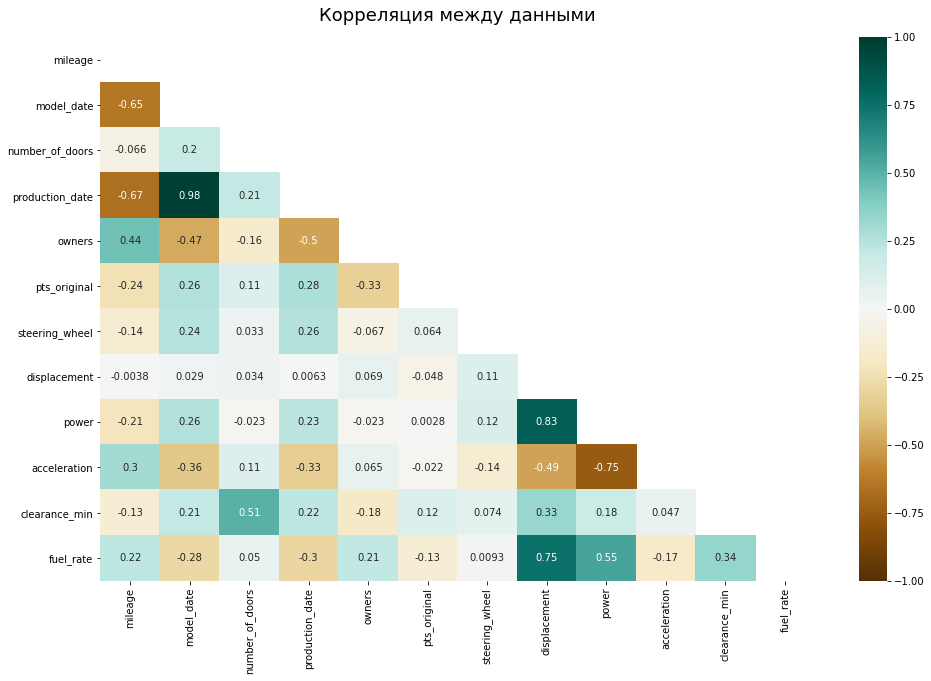

In [255]:
show_num_corr(sum_df, ['mileage', 'model_date', 'number_of_doors', 'production_date', 
                     'owners', 'pts_original', 'steering_wheel', 'displacement', 'power', 
                     'acceleration', 'clearance_min','fuel_rate'])

Text(0.5, 1.0, 'Корреляция между данными')

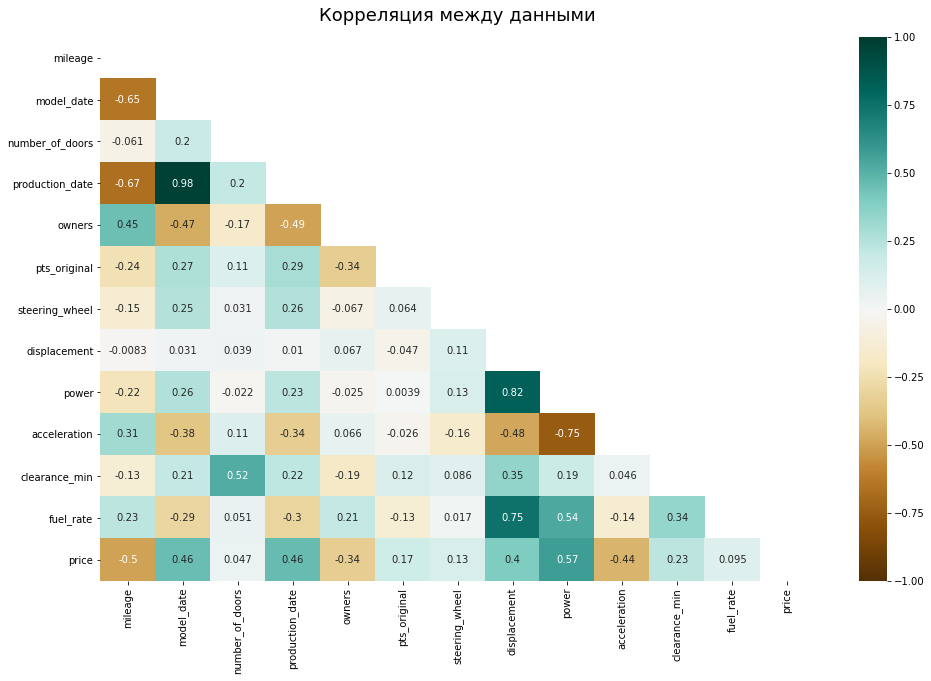

In [256]:
# Скорее всего нужно убрать либо model_date либо production_date
# Посмотрим на связь с целевой переменной
show_num_corr(sum_df[sum_df['price'] > 0], ['mileage', 'model_date', 'number_of_doors', 'production_date', 
                                          'owners', 'pts_original', 'steering_wheel', 'displacement', 'power', 
                                          'acceleration', 'clearance_min','fuel_rate', 'price'])

In [257]:
sum_df.drop('model_date', axis=1, inplace=True)

In [258]:
# Возможно лучше будет удалить объем двигателя
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63440 entries, 0 to 28856
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            63440 non-null  object 
 1   color            63440 non-null  object 
 2   mileage          63440 non-null  int64  
 3   model_name       63440 non-null  object 
 4   number_of_doors  63440 non-null  int64  
 5   production_date  63440 non-null  int64  
 6   owners           63440 non-null  int64  
 7   pts_original     63440 non-null  int64  
 8   steering_wheel   63440 non-null  int64  
 9   body_type        63440 non-null  object 
 10  displacement     63440 non-null  int64  
 11  engine_type      63440 non-null  object 
 12  gear_type        63440 non-null  object 
 13  transmission     63440 non-null  object 
 14  power            63440 non-null  int64  
 15  acceleration     63440 non-null  float64
 16  clearance_min    63440 non-null  float64
 17  fuel_rate   

In [271]:
# Избавимся от дубликатов в трейне
train_df = sum_df[sum_df['price'] > 0]
test_df = sum_df[sum_df['price'] == 0]
print('Кол-во дубликатов в трейне до удаления:', train_df.duplicated().sum())
train_df= train_df.drop_duplicates()
print('Кол-во дубликатов в трейне после удаления:', train_df.duplicated().sum())
sum_df = pd.concat([test_df, train_df])
sum_df.info()

Кол-во дубликатов в трейне до удаления: 237
Кол-во дубликатов в трейне после удаления: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63203 entries, 0 to 28856
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            63203 non-null  object 
 1   color            63203 non-null  object 
 2   mileage          63203 non-null  int64  
 3   model_name       63203 non-null  object 
 4   number_of_doors  63203 non-null  int64  
 5   production_date  63203 non-null  int64  
 6   owners           63203 non-null  int64  
 7   pts_original     63203 non-null  int64  
 8   steering_wheel   63203 non-null  int64  
 9   body_type        63203 non-null  object 
 10  displacement     63203 non-null  int64  
 11  engine_type      63203 non-null  object 
 12  gear_type        63203 non-null  object 
 13  transmission     63203 non-null  object 
 14  power            63203 non-null  int64  
 15  acceleration   

In [272]:
# Сохраним полученный датасет
if os.path.exists('train_test.csv'):
    os.remove('train_test.csv')
sum_df.to_csv('train_test.csv')

## Наивная модель

In [273]:
df = pd.read_csv('train_test.csv', index_col=0)

In [274]:
%%time
# Возьмем среднее по модели и году выпуска
X_train, X_val, y_train, y_val = train_test_split(df[df['price'] > 0].drop('price', axis=1),
                                                  df[df['price'] > 0]['price'], 
                                                  test_size=0.25, random_state=RANDOM_SEED)
naive_train_df = X_train.copy()
naive_train_df['price'] = y_train
mean_price_model = naive_train_df.groupby(['brand', 'model_name', 'production_date'])['price'].mean()
mean_price_pdate = naive_train_df.groupby(['brand', 'production_date'])['price'].mean()
mean_price_brand = naive_train_df.groupby(['brand'])['price'].mean()

def predict(row):
    try:
        return mean_price_model[(row['brand'], row['model_name'], row['production_date'])]
    except KeyError:
        try:
            return mean_price_pdate[(row['brand'], row['production_date'])]
        except KeyError:
            return mean_price_brand[row['brand']]
        
y_pred = X_val.apply(lambda row: predict(row), axis=1)
print('MAPE:', mape(y_val, y_pred))

MAPE: 0.22875663125864631
CPU times: user 361 ms, sys: 5.88 ms, total: 367 ms
Wall time: 369 ms


## Подготовка данных к обучению

In [384]:
df = pd.read_csv('train_test.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63203 entries, 0 to 28856
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            63203 non-null  object 
 1   color            63203 non-null  object 
 2   mileage          63203 non-null  int64  
 3   model_name       63203 non-null  object 
 4   number_of_doors  63203 non-null  int64  
 5   production_date  63203 non-null  int64  
 6   owners           63203 non-null  int64  
 7   pts_original     63203 non-null  int64  
 8   steering_wheel   63203 non-null  int64  
 9   body_type        63203 non-null  object 
 10  displacement     63203 non-null  int64  
 11  engine_type      63203 non-null  object 
 12  gear_type        63203 non-null  object 
 13  transmission     63203 non-null  object 
 14  power            63203 non-null  int64  
 15  acceleration     63203 non-null  float64
 16  clearance_min    63203 non-null  float64
 17  fuel_rate   

In [385]:
def prepare_train_test(train, test, scaler=None):
    """
    Функция для подготовки данных трейна и теста, чтобы использовать ее и для валидации модели
    и для получения предсказаний на тесте принимает уже разделенный на тест и трейн набор
    """
    # Group features
    cat_features = ['brand', 'color', 'model_name', 'body_type', 'engine_type', 'gear_type', 'transmission']
    bin_features = ['pts_original', 'steering_wheel']
    num_features = ['mileage', 'number_of_doors', 'production_date', 'owners', 'displacement', 'power', 
                    'acceleration', 'clearance_min', 'fuel_rate'] 
    target = 'price'
    train_df = train.drop('sell_id', axis=1).copy()
    test_df = test.drop('sell_id', axis=1).copy()
    if 'price' not in test_df.columns:
        test_df['price'] = 0
    train_df['is_train'] = True
    test_df['is_train'] = False
    df = pd.concat([train_df, test_df], axis=0)
    # Encode cat features
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(df[cat_features])
    cat_df = pd.DataFrame(encoder.transform(df[cat_features]), 
                           columns=encoder.get_feature_names(cat_features),
                           index=df.index).astype(int)
    df = pd.concat([cat_df, df.drop(cat_features, axis=1)], axis=1)
    
    # Scale num features
    if scaler is not None:
        df[df['is_train']][num_features] = scaler.fit_transform(df[df['is_train']][num_features])
        df[not df['is_train']][num_features] = scaler.fit_transform(df[not df['is_train']][num_features])
        
    X_train = df[(df['is_train'] == True)].drop(['is_train', target], axis=1)
    X_test = df[(df['is_train'] == False)].drop(['is_train', target], axis=1)
    y_train = df[(df['is_train'] == True)][target]
    y_test = df[(df['is_train'] == False)][target]
    return X_train, X_test, y_train, y_test


In [386]:
class CarPrice():
    """
    Небольшой класс для проверки метрик по моделям
    """
    # Group features
    cat_features = ['brand', 'color', 'model_name', 'body_type', 'engine_type', 'gear_type', 'transmission']
    bin_features = ['pts_original', 'steering_wheel']
    num_features = ['mileage', 'number_of_doors', 'production_date', 'owners', 'displacement', 'power', 
                    'acceleration', 'clearance_min', 'fuel_rate'] 
    target = 'price'
    def __init__(self, train, scaler=None):
        self._X_train = train.drop(self.target, axis=1).copy()
        self._y_train = train[self.target]
        self._scaler = scaler
        self._model = None
        
    def get_X(self):
        return self._prepare(self._X_train)

    def get_y(self):
        return self._y_train
        
    def _encode(self, df):
        raise NotImplementedError('_encode must be implemented')
    
    def _scale(self, df):
        if self._scaler is not None:
            df[self.num_features] = self._scaler.fit_transform(df[self.num_features])
        return df
    
    def _prepare(self, df):
        df = self._encode(df)
        df = self._scale(df)
        return df
        
    def fit(self, model):
        self._model = model
        train = self._prepare(self._X_train)
        self._model.fit(train, np.log(self._y_train))
    
    def predict(self, test):
        assert(self._model is not None)
        return np.exp(self._model.predict(self._prepare(test)))
    
    def print_metrics(self, test):
        metrics = dict()
        y_pred = self.predict(test.drop(self.target, axis=1))
        metrics['mape'] = mape(test[self.target], y_pred)
        for key, val in metrics.items():
            print(f'{key} = {val}')
        return metrics

In [387]:
class CarPriceOneHot(CarPrice):
    def __init__(self, train, scaler=None):
        super().__init__(train, scaler)
        self._categories = None
        
    def _encode(self, df):
        if self._categories is None:
            encoder = OneHotEncoder(sparse=False)
            encoder.fit(df[cat_features])
            self._categories = encoder.categories_
        else:
            encoder = OneHotEncoder(categories=self._categories, sparse=False, handle_unknown='ignore')
            encoder.fit(df[cat_features])
            
        cat_df = pd.DataFrame(encoder.transform(df[cat_features]), 
                              columns=encoder.get_feature_names(cat_features),
                              index=df.index).astype(int)
        return pd.concat([cat_df, df.drop(cat_features, axis=1)], axis=1)
        

In [388]:
#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#X_train, X_val, y_train, y_val = prepare_train_test(df[df['price'] > 0], scaler=StandardScaler()) 
#models, predictions = reg.fit(X_train, X_val, y_train, y_val)
#print(models)

## RandomForestRegressor

In [389]:
%%time
## Without scaler
model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.1424764404953686
CPU times: user 1min 35s, sys: 854 ms, total: 1min 35s
Wall time: 16.7 s


{'mape': 0.1424764404953686}

In [427]:
def plot_feature_imortances(fi, columns, num=20):
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(model.feature_importances_, index=car_price.get_X().columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


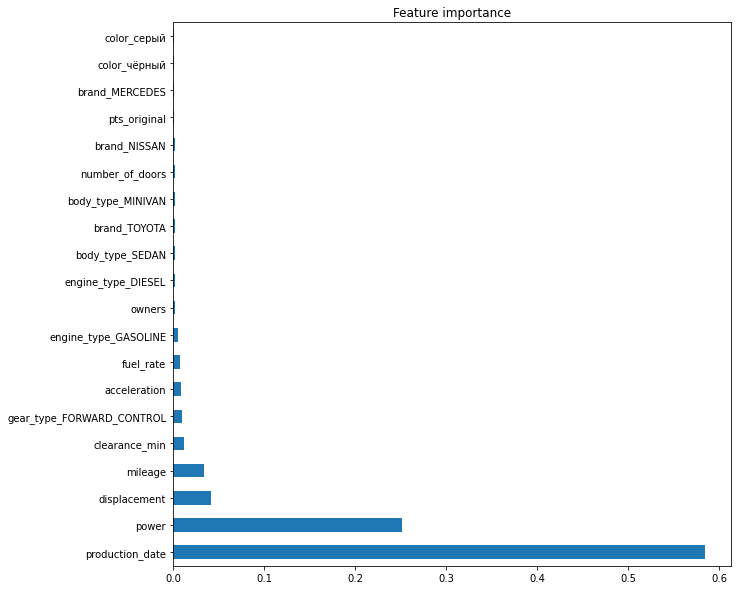

In [428]:
plot_feature_imortances(model.feature_importances_, car_price.get_X().columns)

In [390]:
%%time
## Standard scaler
model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, StandardScaler())
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.14609517720940282
CPU times: user 1min 37s, sys: 803 ms, total: 1min 38s
Wall time: 16.6 s


{'mape': 0.14609517720940282}

In [391]:
%%time
## MinMax scaler
model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, MinMaxScaler())
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.21687660168508135
CPU times: user 1min 37s, sys: 878 ms, total: 1min 38s
Wall time: 17.5 s


{'mape': 0.21687660168508135}

## XGBRegressor

In [430]:
%%time
## Without scaler
model = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.1465282117638691
CPU times: user 2min 34s, sys: 1.28 s, total: 2min 36s
Wall time: 24.6 s


{'mape': 0.1465282117638691}

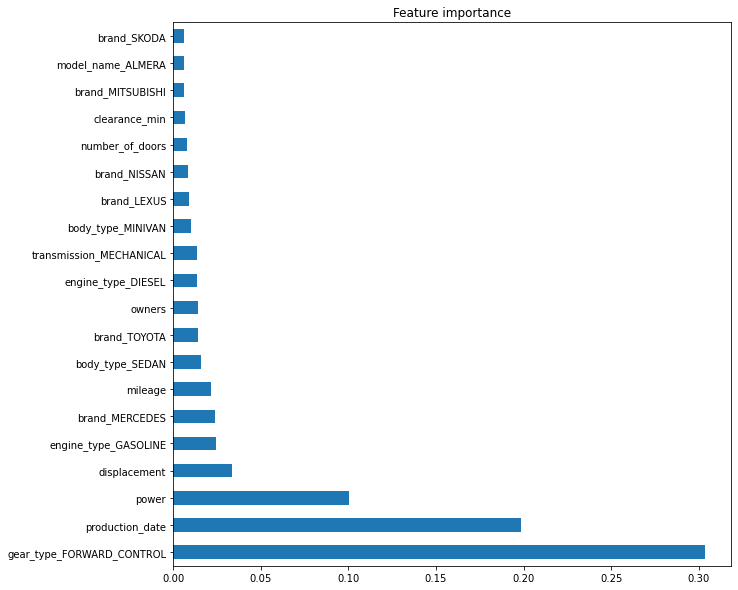

In [449]:
plot_feature_imortances(model.feature_importances_, car_price.get_X().columns)

In [436]:
import optuna
car_price = CarPriceOneHot(train_df)
data = car_price.get_X()
target = car_price.get_y()
def objective(trial, data=data, target=target):    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=VAL_SIZE, random_state=RANDOM_SEED)
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 10.0),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [RANDOM_SEED]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    train_y = np.log(train_y)
    model.fit(train_x, train_y, eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=False)
    preds = model.predict(test_x)
    return mape(test_y, np.exp(preds))

In [437]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-09-08 18:15:48,026] A new study created in memory with name: no-name-a6d7e58b-5943-4ad8-822f-a9c5cf000fc7
<ipython-input-436-6f525674abd5>:20: RuntimeWarning:

overflow encountered in exp

[I 2021-09-08 18:15:53,153] Trial 0 finished with value: inf and parameters: {'lambda': 1.7213566292212112, 'alpha': 1.1898797096727936, 'learning_rate': 3.770185062844886, 'n_estimators': 100, 'max_depth': 20, 'random_state': 42, 'min_child_weight': 155}. Best is trial 0 with value: inf.
[I 2021-09-08 18:16:17,627] Trial 1 finished with value: 0.5289872178865729 and parameters: {'lambda': 0.612140645908713, 'alpha': 0.030491395030665294, 'learning_rate': 0.01613556175849474, 'n_estimators': 200, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 26}. Best is trial 1 with value: 0.5289872178865729.
[I 2021-09-08 18:16:49,788] Trial 2 finished with value: 0.341250558976914 and parameters: {'lambda': 2.2541423228140722, 'alpha': 3.256962482103512, 'learning_rate': 0.08141163650203646, 'n_e

[I 2021-09-08 18:29:12,229] Trial 24 finished with value: 0.487298763539524 and parameters: {'lambda': 0.6895745063371609, 'alpha': 6.764049872568265, 'learning_rate': 0.006812413507474293, 'n_estimators': 500, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 62}. Best is trial 22 with value: 0.14594336992292747.
[I 2021-09-08 18:29:36,596] Trial 25 finished with value: 0.3477414945054982 and parameters: {'lambda': 0.12931805772019037, 'alpha': 0.17087926845019877, 'learning_rate': 0.0438092085794692, 'n_estimators': 500, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 1}. Best is trial 22 with value: 0.14594336992292747.
[I 2021-09-08 18:30:10,539] Trial 26 finished with value: 0.15899705304450285 and parameters: {'lambda': 0.015188410630791703, 'alpha': 1.883923367491628, 'learning_rate': 0.2214993688468927, 'n_estimators': 500, 'max_depth': 15, 'random_state': 42, 'min_child_weight': 27}. Best is trial 22 with value: 0.14594336992292747.
[I 2021-09-08 18:30:44,470] T

[I 2021-09-08 18:43:08,003] Trial 49 finished with value: 0.36493760534864145 and parameters: {'lambda': 0.09946853619885164, 'alpha': 0.16570884945894215, 'learning_rate': 0.07081973325590135, 'n_estimators': 100, 'max_depth': 15, 'random_state': 42, 'min_child_weight': 85}. Best is trial 22 with value: 0.14594336992292747.


Number of finished trials: 50
Best trial: {'lambda': 0.14463332151791242, 'alpha': 1.051037629060312, 'learning_rate': 0.05185149578517971, 'n_estimators': 500, 'max_depth': 15, 'random_state': 42, 'min_child_weight': 16}


In [438]:
optuna.visualization.plot_optimization_history(study)

In [439]:
optuna.visualization.plot_parallel_coordinate(study)

In [440]:
optuna.visualization.plot_slice(study)

In [442]:
optuna.visualization.plot_contour(study, params=['alpha',
                            #'max_depth',
                            'lambda',
                            'learning_rate'])

In [ ]:
%%time
## Without scaler
model = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, reg_lambda=0.15, alpha=1, learning_rate=0.05, 
                         n_estimators=500, max_depth=5, min_child_weight=16)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

## ExtraTreesRegressor

In [470]:
%%time
## Without scaler
model = ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.13945007159254372
CPU times: user 49.5 s, sys: 348 ms, total: 49.8 s
Wall time: 50.4 s


{'mape': 0.13945007159254372}

In [475]:
grid = {'n_estimators': [100, 200],
        'min_samples_leaf': [1, 2, 3, 4]}
model = ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True, n_jobs=-1)
gsc = GridSearchCV(
    estimator=model,
    param_grid=grid,
    cv=5
)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
gsc.fit(car_price.get_X(), car_price.get_y())
car_price.fit(gsc.best_estimator_)
car_price.print_metrics(test_df)

KeyboardInterrupt: 

## CatBoostRegressor

In [451]:
%%time
## Without scaler
model = CatBoostRegressor(iterations=200, depth=7, learning_rate=0.5, loss_function='MAPE', 
                          verbose=0, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.14294472240754896
CPU times: user 5.26 s, sys: 330 ms, total: 5.59 s
Wall time: 1.67 s


{'mape': 0.14294472240754896}

In [458]:
grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'depth': [4, 5, 6, 7, 8, 9],
        'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
model = CatBoostRegressor(loss_function='MAPE', verbose=0, random_state=RANDOM_SEED)
grid_search_result = model.grid_search(grid, 
                                       X=car_price.get_X(), 
                                       y=np.log(car_price.get_y()), 
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.01455198294
bestIteration = 999

0:	loss: 0.0145520	best: 0.0145520 (0)	total: 4.15s	remaining: 18m 36s

bestTest = 0.01144095855
bestIteration = 999

1:	loss: 0.0114410	best: 0.0114410 (1)	total: 8.4s	remaining: 18m 45s

bestTest = 0.01097145309
bestIteration = 999

2:	loss: 0.0109715	best: 0.0109715 (2)	total: 12.9s	remaining: 19m 6s

bestTest = 0.01103671306
bestIteration = 947

3:	loss: 0.0110367	best: 0.0109715 (2)	total: 17.2s	remaining: 19m 1s

bestTest = 0.01177998223
bestIteration = 244

4:	loss: 0.0117800	best: 0.0109715 (2)	total: 21.7s	remaining: 19m 7s

bestTest = 0.01455778658
bestIteration = 999

5:	loss: 0.0145578	best: 0.0109715 (2)	total: 26s	remaining: 19m 2s

bestTest = 0.01143663161
bestIteration = 999

6:	loss: 0.0114366	best: 0.0109715 (2)	total: 30.3s	remaining: 18m 59s

bestTest = 0.01093915683
bestIteration = 999

7:	loss: 0.0109392	best: 0.0109392 (7)	total: 34.6s	remaining: 18m 54s

bestTest = 0.01092453338
bestIteration = 839

8:	loss: 0.01092


bestTest = 0.01239204403
bestIteration = 202

69:	loss: 0.0123920	best: 0.0106684 (57)	total: 5m 35s	remaining: 15m 58s

bestTest = 0.01385082495
bestIteration = 999

70:	loss: 0.0138508	best: 0.0106684 (57)	total: 5m 41s	remaining: 15m 56s

bestTest = 0.01104414034
bestIteration = 999

71:	loss: 0.0110441	best: 0.0106684 (57)	total: 5m 46s	remaining: 15m 53s

bestTest = 0.01070086821
bestIteration = 999

72:	loss: 0.0107009	best: 0.0106684 (57)	total: 5m 52s	remaining: 15m 50s

bestTest = 0.01094437245
bestIteration = 551

73:	loss: 0.0109444	best: 0.0106684 (57)	total: 5m 57s	remaining: 15m 46s

bestTest = 0.01241653296
bestIteration = 247

74:	loss: 0.0124165	best: 0.0106684 (57)	total: 6m 3s	remaining: 15m 43s

bestTest = 0.01387348483
bestIteration = 999

75:	loss: 0.0138735	best: 0.0106684 (57)	total: 6m 8s	remaining: 15m 40s

bestTest = 0.01104740883
bestIteration = 999

76:	loss: 0.0110474	best: 0.0106684 (57)	total: 6m 13s	remaining: 15m 37s

bestTest = 0.01070712779
bestIter


bestTest = 0.01078771188
bestIteration = 983

137:	loss: 0.0107877	best: 0.0105848 (132)	total: 13m 6s	remaining: 12m 31s

bestTest = 0.01194109552
bestIteration = 240

138:	loss: 0.0119411	best: 0.0105848 (132)	total: 13m 14s	remaining: 12m 28s

bestTest = 0.01328997959
bestIteration = 75

139:	loss: 0.0132900	best: 0.0105848 (132)	total: 13m 23s	remaining: 12m 25s

bestTest = 0.0129596342
bestIteration = 999

140:	loss: 0.0129596	best: 0.0105848 (132)	total: 13m 30s	remaining: 12m 21s

bestTest = 0.01084576658
bestIteration = 999

141:	loss: 0.0108458	best: 0.0105848 (132)	total: 13m 38s	remaining: 12m 18s

bestTest = 0.01073397286
bestIteration = 919

142:	loss: 0.0107340	best: 0.0105848 (132)	total: 13m 46s	remaining: 12m 14s

bestTest = 0.01184289664
bestIteration = 207

143:	loss: 0.0118429	best: 0.0105848 (132)	total: 13m 54s	remaining: 12m 10s

bestTest = 0.01351749628
bestIteration = 79

144:	loss: 0.0135175	best: 0.0105848 (132)	total: 14m 2s	remaining: 12m 5s

bestTest = 0.


bestTest = 0.01356810109
bestIteration = 36

204:	loss: 0.0135681	best: 0.0105848 (132)	total: 23m 2s	remaining: 7m 18s

bestTest = 0.01264258998
bestIteration = 999

205:	loss: 0.0126426	best: 0.0105848 (132)	total: 23m 12s	remaining: 7m 12s

bestTest = 0.01080675827
bestIteration = 999

206:	loss: 0.0108068	best: 0.0105848 (132)	total: 23m 22s	remaining: 7m 6s

bestTest = 0.010995646
bestIteration = 959

207:	loss: 0.0109956	best: 0.0105848 (132)	total: 23m 32s	remaining: 7m

bestTest = 0.01200103683
bestIteration = 134

208:	loss: 0.0120010	best: 0.0105848 (132)	total: 23m 44s	remaining: 6m 55s

bestTest = 0.01358648761
bestIteration = 37

209:	loss: 0.0135865	best: 0.0105848 (132)	total: 23m 54s	remaining: 6m 49s

bestTest = 0.01263763026
bestIteration = 999

210:	loss: 0.0126376	best: 0.0105848 (132)	total: 24m 4s	remaining: 6m 43s

bestTest = 0.01082232347
bestIteration = 999

211:	loss: 0.0108223	best: 0.0105848 (132)	total: 24m 14s	remaining: 6m 37s

bestTest = 0.01097086557
b

In [459]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 9, 'learning_rate': 0.1}

In [463]:
%%time
## Without scaler
model = CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9,
                          loss_function='MAPE', verbose=0, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.13441405230828662
CPU times: user 19.3 s, sys: 1.24 s, total: 20.5 s
Wall time: 6.05 s


{'mape': 0.13441405230828662}

## Bagging

In [466]:
%%time
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
base_estimator=ExtraTreeRegressor(random_state=RANDOM_SEED)
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=20, 
                         bootstrap_features=False, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.14458222723588082
CPU times: user 6.05 s, sys: 352 ms, total: 6.4 s
Wall time: 6.47 s


{'mape': 0.14458222723588082}

In [288]:
%%time
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LassoCV
base_estimator=LassoCV(random_state=RANDOM_SEED)
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=10, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

mape = 0.5842111677471128
CPU times: user 50.6 s, sys: 6.55 s, total: 57.1 s
Wall time: 23.6 s


{'mape': 0.5842111677471128}

## Stacking

In [471]:
%%time
from sklearn.ensemble import StackingRegressor
models = [
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, 
                             reg_lambda=0.15, alpha=1, learning_rate=0.05, 
                             n_estimators=500, max_depth=5, min_child_weight=16)),
    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
    ('cat_boost', CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9, loss_function='MAPE', 
                                    verbose=0, random_state=RANDOM_SEED))
]
final_model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200)
model = StackingRegressor(estimators=models, final_estimator=final_model,
                          cv=5, passthrough=True, verbose=2)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
car_price.print_metrics(test_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.3s finished


mape = 0.13530009163291004
CPU times: user 40min 47s, sys: 30.3 s, total: 41min 17s
Wall time: 10min 47s


{'mape': 0.13530009163291004}

In [ ]:
#models = [
#    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, 
#                             reg_lambda=0.15, alpha=1, learning_rate=0.05, 
#                             n_estimators=500, max_depth=5, min_child_weight=16)),
#    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
#    ('cat_boost', CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9, loss_function='MAPE', 
#                                    verbose=0, random_state=RANDOM_SEED))
#]
#{'mape': 0.13509374197208565}

In [ ]:
#models = [
#    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)),
#    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
#    ('cat_boost', CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9, loss_function='MAPE', 
#                                    verbose=0, random_state=RANDOM_SEED))    
#]
#{'mape': 0.13577862207034394}

In [ ]:
#models = [
#    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)),
#    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
#    ('cat_boost', CatBoostRegressor(iterations=200, depth=7, learning_rate=0.5, loss_function='MAPE', 
#                                    verbose=0, random_state=RANDOM_SEED))
#]

# {'mape': 0.137537115994473}

In [358]:
models = [
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)),
    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
    ('cat_boost', CatBoostRegressor(iterations=200, depth=7, learning_rate=0.5, loss_function='MAPE', 
                                    verbose=0, random_state=RANDOM_SEED))
    
]
final_model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200)
model = StackingRegressor(estimators=models, final_estimator=final_model,
                          cv=5, passthrough=True, verbose=2)
model = xgb.XGBRegressor(random_state=RANDOM_SEED)
train_df, test_df = (df[df['price'] > 0], df[df['price'] == 0])
car_price = CarPriceOneHot(train_df)
car_price.fit(model)
y_pred = car_price.predict(test_df.drop('price', axis=1))

In [359]:
submission = df[df['price'] == 0][['sell_id']]
submission['price'] = (y_pred * 0.9)
submission.to_csv(f'submission.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,7.219376e+05
1,1100549428,9.079868e+05
2,1100658222,9.481197e+05
3,1100937408,8.131188e+05
4,1101037972,7.938967e+05
5,1100912634,8.949666e+05
6,1101228730,7.405960e+05
7,1100165896,4.542019e+05
8,1100768262,2.171934e+06
9,1101218501,7.847658e+05


In [383]:
# Из набора в базовом решении получим средний прирост цен по моделям
# df2020 = pd.read_csv('all_auto_ru_09_09_2020.csv')
# on=['brand', 'model_name', 'production_date', 'mileage']
# merged_df = check_df.merge(train_df, left_on=on, right_on=on)
# merged_df['price_diff'] = (merged_df['price_y']  - merged_df['price_x']) / merged_df['price_y']
# diff_by_brand = merged_df.groupby('brand')['price_diff'].mean().to_dict()
diff_by_brand = {
 'AUDI': 0.05960492889225346,
 'BMW': 0.1266654162819937,
 'HONDA': 0.10254400792996447,
 'INFINITI': 0.14075709751506446,
 'LEXUS': 0.0809377567145157,
 'MERCEDES': 0.12201344143747266,
 'MITSUBISHI': 0.11539314028554955,
 'NISSAN': 0.09564299896755538,
 'SKODA': 0.16034701981619512,
 'TOYOTA': 0.12734544830375857,
 'VOLKSWAGEN': 0.09443248432103783,
 'VOLVO': 0.0699287327224045    
}
test_df = df[df['price'] == 0].copy()
test_df['price'] = y_pred
test_df['old_price'] = test_df.apply(lambda row: row['price'] - row['price'] * diff_by_brand[row['brand']], axis=1)
submission = test_df[['sell_id', 'old_price']]
submission.columns = ['sell_id', 'price']
submission.to_csv(f'submission_2020.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,6.735301e+05
1,1100549428,8.471042e+05
2,1100658222,8.845462e+05
3,1100937408,7.585973e+05
4,1101037972,7.406641e+05
5,1100912634,8.349571e+05
6,1101228730,6.909374e+05
7,1100165896,4.237466e+05
8,1100768262,2.026302e+06
9,1101218501,7.321455e+05
